# Functions

## In use

In [14]:
using CSV
using Tables
using DataFrames
using Statistics
using LinearAlgebra
using Plots
using Optim
using NearestNeighbors
plotlyjs()


Plots.PlotlyJSBackend()

In [15]:
function ReadData_i(S,conf,pot)
    Λ = pot/5000
    Λstring = replace(string(round(Λ, digits=2)), "." => "_")
    diffstrat = "autodiff"
    problemName = "PB-S$S-O2-/$diffstrat/Yeoh/PL"
    for s in conf
        problemName = problemName*"_$s"
    end
    pot_10 = 10*pot
    problemName = problemName*"_ϕ$pot_10"
    file_name = "data/csv/" * problemName * "/_Λ_" * Λstring * ".csv"
    _X = CSV.File(file_name) |> Tables.matrix
    x = _X[[1:101...],1]
    return x
end

ReadData_i (generic function with 1 method)

In [16]:
function isomap1(neighbors,Z_)
    n = length(eachcol(Z_))
    D_G = [[] for i in 1:n]
    # count = []
    # count2 = []
    Threads.@threads for i in 1:n
        d_G, prev_ = Dijkstra(Z_,i,neighbors)
        D_G[i] = d_G
        # push!(count,i)
        # ma = maximum(count)
        # push!(count2,ma)
        # mi = minimum(count2)
        # per = round(100*((ma-mi)/(n-mi)))
        # print("\r$ma - $mi - %$per")
    end
    D_G = reduce(hcat,D_G)
    D_G_sym = 0.5*(D_G+D_G')
    D_G_sq = D_G_sym.^2
    C = I - (1/n)*ones(n,n)
    B = -0.5*C*D_G_sq*C
    f(λ) = -real(λ)
    _iso = eigen(B, sortby=f)
    Λ_iso = real.(_iso.values)
    U_iso = real.(_iso.vectors)
    Λ_iso_m = diagm(sqrt.(Λ_iso[[1,2]]))
    U_iso_m = U_iso[:,[1,2]]
    X_iso = U_iso_m*Λ_iso_m
    return X_iso', D_G_sym
end

function Dijkstra(data,i,nieghbors)
    m, n = size(data)
    dist = [Inf64 for i in 1:n]
    prev = [0 for i in 1:n]
    nodes = data
    kdtree = KDTree(nodes; leafsize = 10)
    dist[i] = 0
    visited = []
    dist_ = copy(dist)
    while length(visited)<n
        # println(length(visited))
        u = argmin(dist_)
        append!(visited,u)
        distu = dist[u]
        idxs, dists = knn(kdtree, data[:,u], nieghbors, true,
        x -> maximum(isequal.(x,visited)))
        for i in 1:lastindex(idxs)
            alt = distu + dists[i]
            if alt<dist[idxs[i]]
                dist[idxs[i]]=alt
                prev[idxs[i]]=u
            end
        end
        dist_ = copy(dist)
        dist_[visited].=Inf64
    end
    return dist, prev
end

function ReadData(n_parts,Phi,d)
    X = []
    for i in 1:n_parts, j in Phi
        push!(X,CSV.File("data/csv/EM_PB_4S_Phi$j/EM_PB_4S_$i.csv") |> Tables.matrix)
    end
    X = hcat(X...)
    if d
        m, n = size(X)
        z = zeros(1,n)
        X1 = vcat(X,z)
        X2 = vcat(z,X)
        X3 = (1/0.001)*(X1-X2)
        X = X3[[2:m...],:]
    end
    return X
end

function kPOD(Κ,X,k)
    m, n = size(X)
    # X̄ = [1. for i in 1:n]
    # mean!(X̄',X)
    # for i in 1:n
    #     X[:,i] = X[:,i].-X̄[i]
    # end
    G = [Κ(X[:,i],X[:,j]) for i in 1:n, j in 1:n]
    # display(G)
    II = ones(n,n)
    Ḡ = G - (1/n)*G*II - (1/n)*II*G + (1/n^2)*II*G*II 
    # display(Ḡ)
    f(λ)=-abs(λ)
    Λ_ = eigen(Ḡ,sortby=f)
    Λ = Λ_.values
    U = Λ_.vectors
    Σ = diagm(real.(sqrt.(complex(Λ))))
    Σ_ = Σ[:,[1:k...]]
    U_ = U*pinv(Σ_')
    # U_ = U[:,1:k]
    return Λ, U, U_, Ḡ, G
end


kPOD (generic function with 1 method)

In [17]:
function VectorSearch(Z_,conf,list)
    conf_ = []
    for i in 0:2, j in 0:2, k in 0:2, l in 0:2
    push!(conf_,[i,j,k,l])
    end
    n = length(list)
    z = Z_[:,list]
    v = [z[:,i]-Z_[:,81] for i in 1:n]
    z = Z_[:,81]
    for i in 1:lastindex(conf)
        for j in 1:lastindex(list)
            if conf[i] == conf_[list[j]][i]
                z = z + v[j]
            else
                z = z
            end
        end
    end
    return z
end

VectorSearch (generic function with 1 method)

## Not In use

In [4]:
function DistG_WPlot(i,j,k,k0,data,kdtree)
    t1 = time()
    if i == j
        return D_G = 0.0
    end
    point1 = data[:,i]
    point2 = data[:,j]
    idxs_list = [i]
    Dₑ = norm(point2-point1)
    println("Euclidean distance $Dₑ")
    display(scatter(eachrow(point1)...))
    display(scatter!(eachrow(point2)...))
    display(plot!(eachrow(data[:,[i,j]])...))
    idxs, dists = knn(kdtree, point1, k, false, x -> x==1)
    # display(scatter!(eachrow(data[:,idxs])...))
    indices = sortperm([norm(point2-data[:,id]) for id in idxs])
    idxs = idxs[indices[[1:k0...]]]
    push!(idxs_list,idxs[1])
    display(scatter!(eachrow(data[:,idxs])...))
    Dist = norm(point2-data[:,idxs[1]])
    while Dist>0.0
        idxs_ = []
        for idx in idxs
            append!(idxs_,idx)
        end
        idxs = idxs_
        indices = sortperm([norm(point2-data[:,id]) for id in idxs])
        idxs = idxs[indices[[1:k0...]]]
        display(scatter!(eachrow(data[:,idxs])...))
        Dist = norm(point2-data[:,idxs[1]])
        push!(idxs_list,idxs[1])
        println("How close: $Dist")
        idxs, dists = knn(kdtree, data[:,idxs], k, true, x -> maximum(isequal.(x,idxs)))
        
        # display(scatter!(eachrow(data[:,idxs_])...))
        # println(i)
    end
    display(plot!(eachrow(data[:,idxs_list])...))
    point0 = data[:,idxs_list[1]]
    D_G = 0
    for idx in idxs_list
        D_pair = norm(data[:,idx]-point0)
        D_G += D_pair
        println("Accumulative distance $D_G")
        println("Pair distance $D_pair")
        point0 = data[:,idx]
    end
    println(time()-t1)
    return D_G, Dₑ
end

function DistG(i,j,k,k0,data,kdtree)
    t1 = time()
    if i == j
        return D_G = 0.0
    end
    pair = (i,j)
    println("Current $pair")
    point1 = data[:,i]
    point2 = data[:,j]
    idxs_list = [i]
    Dₑ = norm(point2-point1)
    # println("Euclidean distance $Dₑ")
    # display(scatter(eachrow(point1)...))
    # display(scatter!(eachrow(point2)...))
    # display(plot!(eachrow(data[:,[1,2]])...))
    idxs, dists = knn(kdtree, point1, k, false, x -> x==1)
    # display(scatter!(eachrow(data[:,idxs])...))
    indices = sortperm([norm(point2-data[:,id]) for id in idxs])
    idxs = idxs[indices[[1:k0...]]]
    push!(idxs_list,idxs[1])
    # display(scatter!(eachrow(data[:,idxs])...))
    Dist = norm(point2-data[:,idxs[1]])
    while Dist>0.0
        idxs_ = []
        for idx in idxs
            append!(idxs_,idx)
        end
        idxs = idxs_
        indices = sortperm([norm(point2-data[:,id]) for id in idxs])
        idxs = idxs[indices[[1:k0...]]]
        # display(scatter!(eachrow(data[:,idxs])...))
        Dist = norm(point2-data[:,idxs[1]])
        push!(idxs_list,idxs[1])
        # println("How close: $Dist")
        idxs, dists = knn(kdtree, data[:,idxs], k, true, x -> maximum(isequal.(x,idxs)))
        
        # display(scatter!(eachrow(data[:,idxs_])...))
        # println(i)
    end
    # display(plot!(eachrow(data[:,idxs_list])...))
    point0 = data[:,idxs_list[1]]
    D_G = 0
    for idx in idxs_list
        D_G += norm(data[:,idx]-point0)
        point0 = data[:,idx]
    end
    println(time()-t1)
    return D_G
end

function isomap0(Distance,X,kdtree,k,k_n)
    m, n = size(X)
    G = [Distance(i,j,k_n,1,X,kdtree) for i in 1:n, j in 1:n]
    G = 0.5*(G+G')
    H = I - (1/n)*ones(n,n)
    G = 0.5*H'*G*H
    f(λ)=-abs(λ)
    Λ_ = eigen(G,sortby=f)
    Λ = Λ_.values
    U = Λ_.vectors
    # U_ = U[:,1:k]
    return Λ, U, G
end


isomap0 (generic function with 1 method)

In [5]:
function PlotSetup(X_,k)
    X_pl = []
    for i in 1:k
        push!(X_pl,X_[i,:])
    end
    return X_pl
end

function PlotSetupN(X_,k)
    X_pl = []
    for i in 1:k
        push!(X_pl,X_[i,:])
    end
    N_pl = [i for i in 1:length(X_pl[1])]
    pushfirst!(X_pl,N_pl)
    return X_pl
end

function plotkPOD(Ḡ,U_,k,d)
    m, n = size(Ḡ)
    Z_ = U_'*Ḡ #Corregir uso de G y usar la ecuación 2.28 del capitulo del libro
    # Z_ = abs.(Z_)
    Z_ = real.(Z_)
    Z_pl = PlotSetup(Z_,k)
    s = scatter(Z_pl...,xlabel="z1",ylabel="z2",zlabel="z3", hover= [i for i in 1:n])#, markercolor= [Int(ceil(i/l)) for i in 1:n])
    display(s)
end

function execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Λ_t = sum(Λ)
    Λ = (1/Λ_t)*Λ
    Λ_s = round.(100*Λ[[i for i in 1:10]])
    p = plot(real.(Λ_s),type="bar",xlabel="λ",ylabel="%", legend=false, hover=real.(Λ_s))
    display(p)
    if k<=3
        plotkPOD(Ḡ,U_,k,d)
    else
        plotkPOD(Ḡ,U_,3,d)
    end
    return X, U_, Ḡ
end


execute_kPOD (generic function with 1 method)

In [6]:
function ReverseMap(X,Z_,z,d,n)
    w = [1/sqrt(dot(z-zi,z-zi)) for zi in eachcol(Z_)]
    # w = [exp(-sqrt(dot(z-zi,z-zi))) for zi in eachcol(Z_)]
    # display(w)
    w_sort = sortperm(w, rev=true)
    w_ns = [w[w_sort[1]]]
    X_ns = X[:,w_sort[1]]
    Z_ns = Z_[:,w_sort[1]]
    for i in 2:n
        push!(w_ns,w[w_sort[i]])
        X_ns = hcat(X_ns,X[:,w_sort[i]])
        Z_ns = hcat(Z_ns,Z_[:,w_sort[i]])
    end
    # w_ns = w_ns/sum(w_ns)
    w_ns = pinv(Z_ns)*z
    w_ns = w_ns/sum(w_ns)
    x = X_ns*w_ns
    if d
        y = [0.004]
        n = length(x)
        for i in 1:n
            push!(y,y[i]+0.001*real.(x[i]))
        end
        x=y
    end
    return x, w_ns, Z_ns
end

function ReverseMap2(y_gen,conf_gen,Y_,X,conf,nh,t)
    x_gen = []
    for j in 1:10
        param1 = []
        for i in 1:n
            push!(param1,conf[j,i])
        end
        sort_param1 = sortperm(param1)
        group_param = 0
        group = [[],[],[]]
        count = 1
        for i in 1:n
            if param1[sort_param1[i]]==group_param
                push!(group[count],sort_param1[i])
            else
                count += 1
                group_param += 1
                push!(group[count],sort_param1[i])
            end
        end
        param1_test = conf_gen[j]
        param1_test += 1
        sec = [((10*(j-1)+1)):((10*j)+1)...]
        # if j==10
        #     append!(sec,101)
        # end
        x_gen_j, w_ns, Z_ns = ReverseMap(X[:,group[param1_test]][sec,:],
        Y_[:,group[param1_test]],y_gen,false,nh)
        push!(x_gen,x_gen_j)
    end
    for i in 2:10
        Δ = x_gen[i][begin]-x_gen[i-1][end]
        x_gen[i] = x_gen[i].-Δ
        θ1 = atan((x_gen[i-1][end] - x_gen[i-1][end-1])/0.001)
        θ2 = atan((x_gen[i][begin+1] - x_gen[i][begin])/0.001)
        Δθ = θ1 - θ2
        # Δθ = Δθ*1.5
        # display((Δθ*(180/pi)))
        rot = [cos(Δθ) -sin(Δθ); sin(Δθ) cos(Δθ)]
        # display(rot)
        x_gen_i = x_gen[i]
        b = x_gen_i[1]
        x_gen_i = x_gen_i.- b
        x_ = [0:10...]
        x_ = x_./1000
        X_ = hcat(x_,x_gen_i)
        X_ = X_'
        # # Poly2(z) = [1 z z^2 z^3]
        # Poly2(z) = [1 z z^2]
        # A = Poly2.(X_[1,:])
        # A = reduce(vcat,A)
        # c = pinv(A)*X_[2,:]
        # # Poly_d(z) = [0 1 2*z 3*z^2]
        # Poly_d(z) = [0 1 2*z]
        # A = Poly_d(-t)
        # θ2 = A*c
        # Δθ = θ1 - θ2[1]
        # rot = [cos(Δθ) -sin(Δθ); sin(Δθ) cos(Δθ)]
        # plot(eachrow(X_)...)
        X_ = rot*X_
        # plot!(eachrow(X_)...)
        Poly(z) = [1 z z^2 z^3]
        A = Poly.(X_[1,:])
        A = reduce(vcat,A)
        c = pinv(A)*X_[2,:]
        A = Poly.(x_)
        A = reduce(vcat,A)
        x_gen[i] = A*c
        # display(plot!(x_,x_gen[i],title="$i"))
        x_gen[i] .+= b
    end
    for i in 1:lastindex(x_gen)-1
        pop!(x_gen[i])
    end
    x_gen_0 = reduce(append!,x_gen)
    x_gen_0 =  1.10145.*x_gen_0
    return x_gen_0
end

function RotM(v1,v2)
    v = cross(v1,v2)
    vₓ = [0 -v[3] v[2]; v[3] 0 -v[1]; -v[2] v[1] 0]
    c = dot(v1,v2)
    R = I + vₓ + (1/(1+c))*vₓ*vₓ
    return R
end


RotM (generic function with 1 method)

In [7]:
function Objective1(β)
    println("Kernel parameter: $β")
    P = [2000] #,4000]
    n_parts = 8
    k = 3
    d = false
    # Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Κ(X1,X2) = (Der2nd(X1,0.001)'*Der2nd(X2,0.001) + β)^2
    # Κ(X1,X2) = (X1'*X2 + β)^2
    # X, U_, Ḡ = execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Z_ = real.(U_'*Ḡ)
    final = lastindex(eachcol(Z_))
    D = Dif(Z_,final-21,final-12,final-11,final)
    return D
    # return 1-(abs(maximum(Z_[2,:]))/abs(maximum(Z_[1,:])))
end

function Objective2(β)
    println("Kernel parameter: $β")
    P = [2000] #,4000]
    n_parts = 6
    k = 3
    d = false
    # Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Κ(X1,X2) = (X1'*X2 + β)^2
    # X, U_, Ḡ = execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    R = []
    err = []
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Z_ = real.(U_'*Ḡ)

    # -------Curve fitting------
    # Quadric surface explicit in z3 of the form z3 = A + B*z1^2 + Cz2^2 + D*z1 + E*z2
    Quadric(z) = [1 z[1]^2 z[2]^2 z[1] z[2]] 

    # least squares fit of the curve to the TS in the RS
    A = [Quadric(Z) for Z in eachcol(Z_)]
    A = reduce(vcat,A)
    c = pinv(A)*Z_[3,:]
    
    #Definition of surface and unit gradient
    z3(z1,z2) = c[1] + c[2]*z1^2 + c[3]*z2^2 + c[4]*z1 + c[5]*z2
    ∇zᵤ(z1,z2) = (1/norm([2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]))*[2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]

    SS_reg = sqrt(dot(Z_[3,:]-z3.(Z_[1,:],Z_[2,:]),Z_[3,:]-z3.(Z_[1,:],Z_[2,:])))
    avr = sum(Z_[3,:])/length(Z_[3,:])
    SS_tot = sqrt(dot(Z_[3,:].-avr,Z_[3,:].-avr))
    R_sq = 1-SS_reg/SS_tot
    append!(R,sqrt(R_sq))
    println("R1 = $R")

    # Whole RS found using VectorSearch and considering ∇zᵤ
    z_ = []
    for c in eachcol(conf)
        z = VectorSearch(Z_,c,∇zᵤ); z = real.(z)
        push!(z_,z)
    end
    z_ = reduce(hcat,z_)

    # evaluation of the distributted error - Applicable if using the whole RS as the TS
    append!(err,norm(Z_-z_)/norm(Z_))
    println("Err1 = $err")

    Z_c = Z_[3,:]
    Z_[3,:] = Z_[2,:]
    Z_[2,:] = Z_c
    
    A = [Quadric(Z) for Z in eachcol(Z_)]
    A = reduce(vcat,A)
    c = pinv(A)*Z_[3,:]
    
    #Definition of surface and unit gradient
    z3(z1,z2) = c[1] + c[2]*z1^2 + c[3]*z2^2 + c[4]*z1 + c[5]*z2
    ∇zᵤ(z1,z2) = (1/norm([2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]))*[2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]

    SS_reg = sqrt(dot(Z_[3,:]-z3.(Z_[1,:],Z_[2,:]),Z_[3,:]-z3.(Z_[1,:],Z_[2,:])))
    avr = sum(Z_[3,:])/length(Z_[3,:])
    SS_tot = sqrt(dot(Z_[3,:].-avr,Z_[3,:].-avr))
    R_sq = 1-SS_reg/SS_tot
    append!(R,sqrt(R_sq))
    println("R2 = $R")

    # Whole RS found using VectorSearch and considering ∇zᵤ
    z_ = []
    for c in eachcol(conf)
        z = VectorSearch(Z_,c,∇zᵤ); z = real.(z)
        push!(z_,z)
    end
    z_ = reduce(hcat,z_)

    # evaluation of the distributted error - Applicable if using the whole RS as the TS
    append!(err,norm(Z_-z_)/norm(Z_))
    println("Err2 = $err")

    if R[1]>R[2]
        err = err[1]
        println("Err1 & R1")
    else
        err = err[2]
        println("Err2 & R2")
    end
    
    return err
end

function Objective3(β)
    println("Kernel parameter: $β")
    P = [2000] #,4000]
    n_parts = 6
    k = 3
    d = false
    # Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Κ(X1,X2) = (X1'*X2 + β)^2
    # X, U_, Ḡ = execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    R = []
    err = []
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Z_ = real.(U_'*Ḡ)

    kdtree = KDTree(Z_; leafsize = 10)
    data = Z_
    k0 = 1
    k_n = 30
    k1 = 2
    Λ, U, G = isomap0(DistG,data,kdtree,k1,k_n)
    Σ = diagm(real.(sqrt.(complex(-Λ))))
    Σ_ = Σ[:,[1:2...]]
    Z_ = real.(Σ_'*U)
    
    # Whole RS found using VectorSearch
    z_ = []
    for c in eachcol(conf)
        z = VectorSearch(Z_,c); z = real.(z)
        push!(z_,z)
    end
    z_ = reduce(hcat,z_)

    # evaluation of the distributted error - Applicable if using the whole RS as the TS
    err = norm(Z_-z_)/norm(Z_)
    
    return err
end

function Objective4(β)
    println("Kernel parameter: $β")
    P = [4000] #,4000]
    n_parts = 8
    k = 3
    d = false
    Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    # Κ(X1,X2) = (X1'*X2 + β)^2
    # X, U_, Ḡ = execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Z_ = real.(U_'*Ḡ)
    D = -Dist(Z_,601,600)
    return D
    # return 1-(abs(maximum(Z_[2,:]))/abs(maximum(Z_[1,:])))
end

function Objective5(β)
    println("Kernel parameter: $β")
    P = [2000] #,4000]
    n_parts = 8
    k = 3
    d = false
    # Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    # Κ(X1,X2) = (X1'*X2 + β)^2
    # Κ(X1,X2) = (Der2nd(X1,0.001)'*Der2nd(X2,0.001) + β)^2
    Κ(X1,X2) = exp(-β*(dot(Der2nd(X1,0.001)-Der2nd(X2,0.001),Der2nd(X1,0.001)-Der2nd(X2,0.001))))
    # X, U_, Ḡ = execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Z_ = real.(U_'*Ḡ)
    Last = lastindex(eachcol(Z_))
    d_G, prev_ = Dijkstra(Z_,1,25) # conf 0000000000
    d1 = d_G[10] # conf 0100000000
    d_G, prev_ = Dijkstra(Z_,11,25) # conf 1000000000
    d2 = d_G[22] # conf 1100000000
    D = abs(d2-d1)/d1
    return D
    # return 1-(abs(maximum(Z_[2,:]))/abs(maximum(Z_[1,:])))
end

function Objective7(β)
    println("Kernel parameter: $β")
    P = [2000] #,4000]
    n_parts = 8
    k = 3
    d = false
    # Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Κ(X1,X2) = (X1'*X2 + β)^2
    # X, U_, Ḡ = execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Z_ = real.(U_'*Ḡ)
    neighbors = 25
    to = time()
    Y_, D_G_sym = isomap1(neighbors,Z_)
    println("elapsed time for isomap")
    println(time()-to)
    Y_gen = []
    Last = lastindex(eachcol(Y_))
    for i in 1:Last
        y_ = VectorSearch(Y_,conf[:,i])
        push!(Y_gen,y_)
    end
    Y_gen = reduce(hcat,Y_gen)
    D = norm(Y_gen-Y_)/norm(Y_)
    println("Err = $D")
    return D
end

function Objective8(β)
    println("Kernel parameter: $β")
    P = [2000] #,4000]
    n_parts = 8
    k = 3
    d = false
    # Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Κ(X1,X2) = (Der2nd(X1,0.001)'*Der2nd(X2,0.001) + β)^2
    # Κ(X1,X2) = (X1'*X2 + β)^2
    # X, U_, Ḡ = execute_kPOD(Κ,P,n_parts,k,d)
    X = ReadData(n_parts,P,d)
    Λ, U, U_, Ḡ = kPOD(Κ,X,k)
    Λ = real.(Λ)
    Λ_t = sum(Λ)
    Λ_3 = sum(Λ[[1,2,3]])
    Res = Λ_3/Λ_t
    println("Info in first 3 directcions: $Res")
    return 1-Res
    # return 1-(abs(maximum(Z_[2,:]))/abs(maximum(Z_[1,:])))
end


function NewData(x_test,Κ,neighbors,G,Z_,D_G_sym)
    Κ_test(X) = Κ(x_test,X)
    g_i = Κ_test.(eachcol(X))
    ḡ_i = g_i - (1/n)*G*ones(n,1) - (1/n)*ones(n,n)*g_i +
    ((1/n^2)*ones(1,n)*G*ones(n,1))[1]*ones(n,1)
    z_i = real.(U_'*ḡ_i)
    # scatter!(eachrow(z_i)..., hover = [i for i in 1:lastindex(eachcol(Z_))])
    Z_i = hcat(Z_,z_i)
    Last = lastindex(eachcol(Z_i))
    d_G_i, prev_ = Dijkstra(Z_i,Last,neighbors)
    D_G_i = vcat(hcat(D_G_sym,d_G_i[[1:n...]]),d_G_i')
    D_G_sq_i = D_G_i.^2
    C_i = I - (1/(n+1))*ones(n+1,n+1)
    B_i = -0.5*C_i*D_G_sq_i*C_i
    f(λ) = -real(λ)
    _iso_i = eigen(B_i, sortby=f)
    Λ_iso_i = real.(_iso_i.values)
    U_iso_i = real.(_iso_i.vectors)

    Λ_iso_m_i = diagm(sqrt.(Λ_iso_i[[1,2]]))
    U_iso_m_i = U_iso_i[:,[1,2]]

    X_iso_i = U_iso_m_i*Λ_iso_m_i
    X_iso_i = X_iso_i'
    return X_iso_i[:,Last]
end

Dist(Z_,i1,i2) = sqrt(dot(real.(Z_[:,i1]-Z_[:,i2]),real.(Z_[:,i1]-Z_[:,i2])))
Dif(Z_,i,j,k,l) = abs((Dist(Z_,k,l)-Dist(Z_,i,j))/Dist(Z_,i,j))


Dif (generic function with 1 method)

# ROM Offline

## Data colection

### New Data

In [7]:
cd("C:/Users/mjbarillas/Documents/GitHub/Mimosa/")
S,conf,pot  = 4,[1,0,0,1,1,0,0,1],5000.0
x_i_ = ReadData_i(S,conf,pot)

101-element Vector{Float64}:
 0.0002970982639997349
 0.00030358874777813383
 0.0003230593331129278
 0.0003555073379488125
 0.00040092807028440806
 0.0004593154790304215
 0.0005306624712070613
 0.0006149602477022274
 0.0007121991832793346
 0.000822369912695155
 ⋮
 0.016096333778933773
 0.016193610108714566
 0.016277954752473477
 0.016349355776816527
 0.01640779584175601
 0.016453252719931224
 0.016485697765737786
 0.0165050616739124
 0.01651158360039873

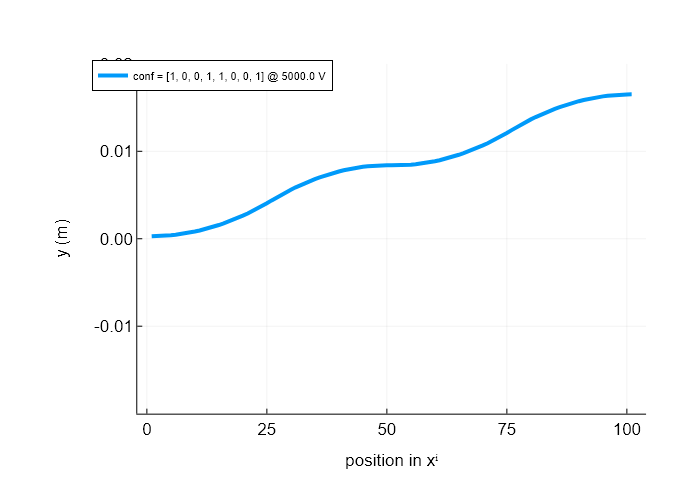

In [8]:
plot(x_i_,
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(conf) @ $pot V",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-0.02,0.02)
)

In [23]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB4S_FOS_10011001_5kV.svg")

"G:\\My Drive\\Temp\\Comunication\\ROM_Paper\\PB4S_FOS_10011001_5kV.svg"

In [1]:
x_i(conf) = ReadData_i(S,conf,pot)

x_i (generic function with 1 method)

In [2]:
Conf = []
for i1 in 0:1, i2 in 0:1, i3 in 0:1, i4 in 0:1, i5 in 0:1, i6 in 0:1, i7 in 0:1, i8 in 0:1
    push!(Conf,[i1,i2,i3,i4,i5,i6,i7,i8])
end


In [9]:
X = x_i.(Conf)

256-element Vector{Vector{Float64}}:
 [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004  …  0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004]
 [0.000400000000000166, 0.00040000000000017214, 0.00040000000000019165, 0.00040000000000022824, 0.0004000000000002891, 0.00040000000000038513, 0.0004000000000005315, 0.0004000000000007518, 0.0004000000000010818, 0.00040000000000157233  …  -0.0011831107564698252, -0.0013955934430497025, -0.0016207393196964626, -0.001858504572511992, -0.002108844012147975, -0.0023717156766404003, -0.002647087456997003, -0.0029349342950730057, -0.0032352762994425585, -0.0035478747265689035]
 [0.000399999999999772, 0.0003999999999997581, 0.00039999999999971536, 0.0003999999999996403, 0.0003999999999995257, 0.00039999999999936104, 0.00039999999999913125, 0.0003999999999988127, 0.00039999999999837025, 0.0003999999999977529  …  0.0019831107564269026, 0.0021955934430060793, 0.002420739319652143, 0.00265850457246

In [10]:
X = reduce(hcat,X)

101×256 Matrix{Float64}:
 0.0004   0.0004      0.0004      0.0004  …   0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004  …   0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 ⋮                                        ⋱                           ⋮
 0.0004  -0.00139559  0.00219559  0.0004     -0.0014128   0.0022128   0.0004
 0.0004  -0.00162074  0.00242074  0.0004     -0.00163881

### Old Data

In [8]:
cd("C:/Users/mjbarillas/Documents/GitHub/Mimosa/")

In [9]:
n_p, P, d = 3, [2000], false
# Training Set in the full-order space
X = ReadData(n_p, P, d)

101×81 Matrix{Float64}:
 0.0004       0.0004       0.0004       …  0.0004       0.0004      0.0004
 0.000402034  0.000402034  0.000402034     0.0004       0.0004      0.0004
 0.000413126  0.000413126  0.000413126     0.0004       0.0004      0.0004
 0.000435147  0.000435147  0.000435147     0.0004       0.0004      0.0004
 0.00046883   0.00046883   0.00046883      0.0004       0.0004      0.0004
 0.000514287  0.000514287  0.000514287  …  0.0004       0.0004      0.0004
 0.0005713    0.0005713    0.0005713       0.0004       0.0004      0.0004
 0.00063965   0.00063965   0.00063965      0.0004       0.0004      0.0004
 0.000719169  0.000719169  0.000719169     0.0004       0.0004      0.0004
 0.000809688  0.000809688  0.000809688     0.0004       0.0004      0.0004
 ⋮                                      ⋱                           ⋮
 0.0421167    0.0400128    0.0411146       0.00193931  -0.00113931  0.0004
 0.0429527    0.0405898    0.0418326       0.0021268   -0.0013268   0.0004
 0.043

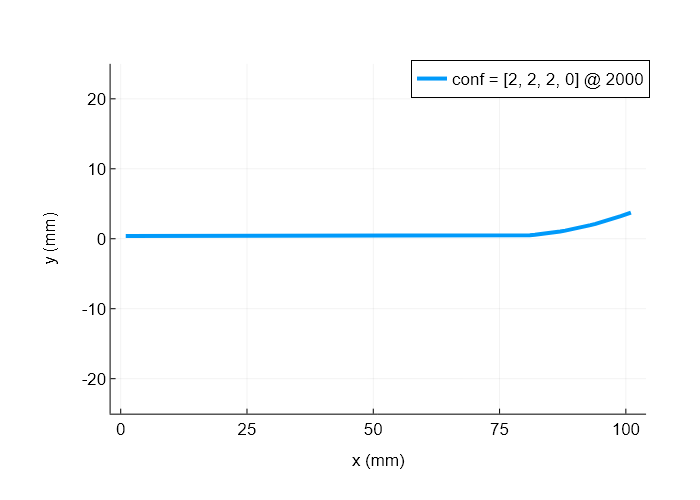

In [114]:
v = 79
plot(1000*X[:,v],
xlabel ="x (mm)",
ylabel = "y (mm)",
linewidth=4,
label="conf = $(conf[v]) @ $(P[1])",
legendfontsize=12,
guidefontsize=12,
tickfontsize=12,
# legend=:topleft,
ylims=(-25.0,25.0)
)

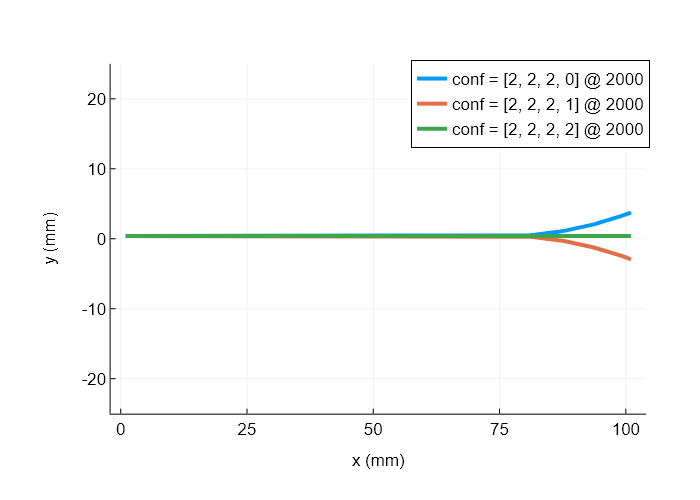

In [116]:
v = 81
plot!(1000*X[:,v],
xlabel ="x (mm)",
ylabel = "y (mm)",
linewidth=4,
label="conf = $(conf[v]) @ $(P[1])",
legendfontsize=12,
guidefontsize=12,
tickfontsize=12
)

In [118]:
Plots.savefig("G:/My Drive/Temp/Comunication/Presentation Potential Oct/PB4S_FOS_79_81_82.svg")

"G:\\My Drive\\Temp\\Comunication\\Presentation Potential Oct\\PB4S_FOS_79_81_82.svg"

## kPCA

In [11]:
# Number of principal directions to be considered
k = 3
#Gaussian Kernel
β = 1


1

In [12]:
β = 0.0925568394055076

0.0925568394055076

In [18]:
Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
# Polynomial Kernel
# Κ(X1,X2) = (X1'*X2 + 10)^2
Λ, U, U_, Ḡ = kPOD(Κ, X, k)

(ComplexF64[0.7341206682000333 + 0.0im, 0.01629115932871815 + 0.0im, 0.0020757578093202394 + 0.0im, 0.0016207309008834138 + 0.0im, 0.00024001857638737166 + 0.0im, 3.0603230685030667e-5 + 0.0im, 3.4308495598436145e-6 + 0.0im, 1.7201623061388106e-6 + 0.0im, 1.1255948770200662e-6 + 0.0im, 5.722323119018221e-7 + 0.0im  …  4.803195278812425e-17 - 4.832699484396005e-18im, -3.309749566037104e-17 + 0.0im, -3.4412832724059273e-18 + 3.0661532788017397e-17im, -3.4412832724059273e-18 - 3.0661532788017397e-17im, -2.5049461422641728e-17 + 1.2365522506287317e-17im, -2.5049461422641728e-17 - 1.2365522506287317e-17im, 2.1458584722003063e-17 + 0.0im, -1.978918064340117e-17 + 0.0im, 1.4541863741109598e-17 + 0.0im, -1.236791597518913e-17 + 0.0im], ComplexF64[1.4721737561124768e-13 + 0.0im 6.180174086702796e-14 + 0.0im … 0.09546001287246346 + 0.0im 0.0199513680881662 + 0.0im; -0.0030950359737205242 + 0.0im -0.016586076706669315 + 0.0im … 0.034334087617746305 + 0.0im 0.06071191492546117 + 0.0im; … ; 0.00312

In [19]:
# Training Set in the reduced space
Z_ = real.(U_'*Ḡ)

3×256 Matrix{Float64}:
  1.26183e-13  -0.00265185   0.00265185  …   0.00268046  -3.28991e-13
  7.60588e-15  -0.00211699   0.00211699      0.00213337  -1.48985e-14
 -0.0025131    -0.00250446  -0.00250446     -0.0025043   -0.0025131

In [22]:
gr()

Plots.GRBackend()

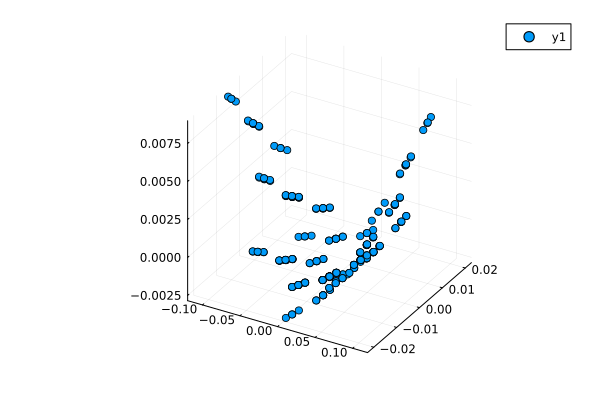

In [23]:
scatter(eachrow(Z_)...)

In [14]:
#Generation of full set of parameters in order
conf = []
for i in 0:2, j in 0:2, k in 0:2, l in 0:2
  push!(conf,[i,j,k,l])
end


In [ ]:
conf

In [15]:
VS_Conf = [
    [2,2,2,2],
    [0,2,2,2],
    [2,0,2,2],
    [2,2,0,2],
    [2,2,2,0],
    [1,2,2,2],
    [2,1,2,2],
    [2,2,1,2],
    [2,2,2,1],
]

VS_Conf_list = []
for i in 1:9
    j = 0
    for c in conf
        j+=1
        if VS_Conf[i]==c
            push!(VS_Conf_list,j)
        end
    end
end
VS_Conf_list


9-element Vector{Any}:
 81
 27
 63
 75
 79
 54
 72
 78
 80

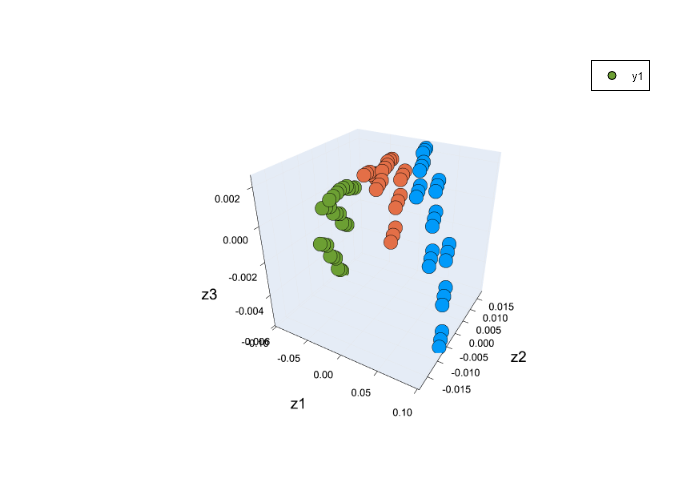

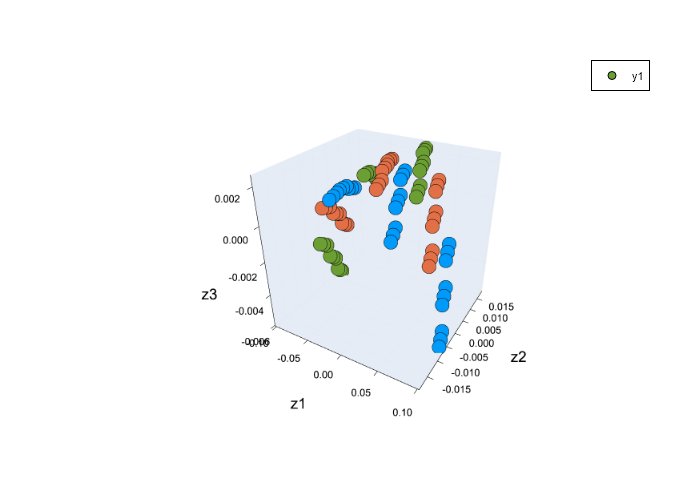

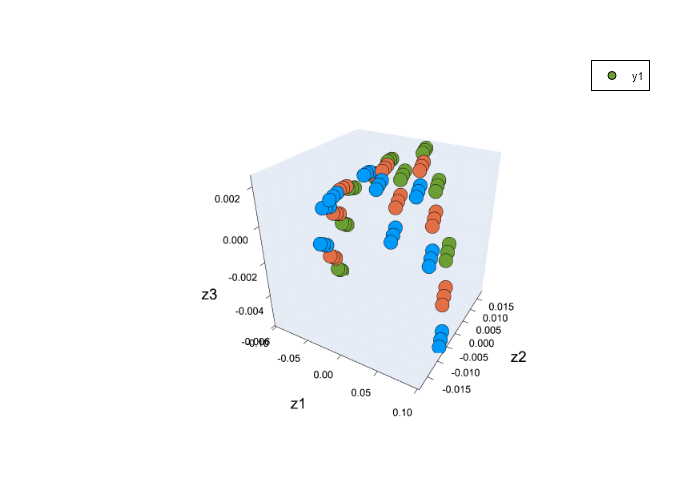

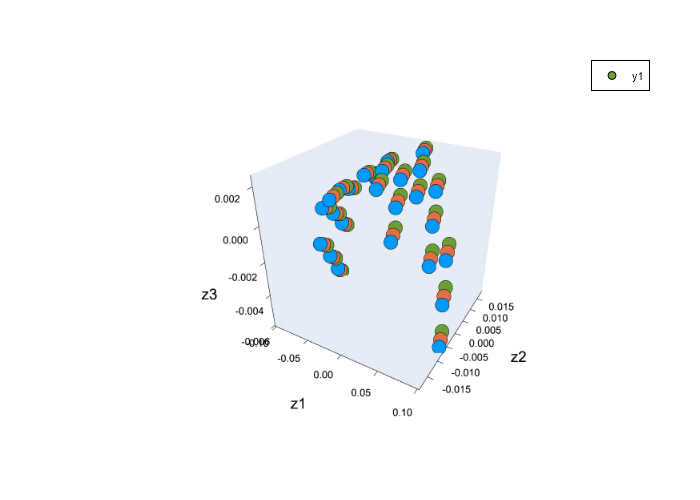

In [16]:

# Scatter plot of the TS in RS - Colored parameters
for i in 1:4
    display(scatter(eachrow(Z_)...,xlabel="z1",ylabel="z2",zlabel="z3", 
    hover= [i for i in 1:lastindex(eachcol(Z_))],
    markercolor = [c[i] for c in conf]
    ))
    # savefig("data/Figs/kPCA_PB_S4_Phi2000/RSvsParameters_$i.png")
end


## Fit surface for visualization

In [24]:
# -------Curve fitting------
# Quadric surface explicit in z3 of the form z3 = A + B*z1^2 + Cz2^2 + D*z1 + E*z2
Quadric(z) = [1 z[1]^2 z[2]^2 z[1] z[2]] 

# least squares fit of the curve to the TS in the RS
A = [Quadric(Z) for Z in eachcol(Z_)]
A = reduce(vcat,A)
c = pinv(A)*Z_[3,:]

#Definition of surface and unit gradient
z3(z1,z2) = c[1] + c[2]*z1^2 + c[3]*z2^2 + c[4]*z1 + c[5]*z2
∇zᵤ(z1,z2) = (1/norm([2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]))*[2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]

∇zᵤ (generic function with 1 method)

In [22]:
gr()

Plots.GRBackend()

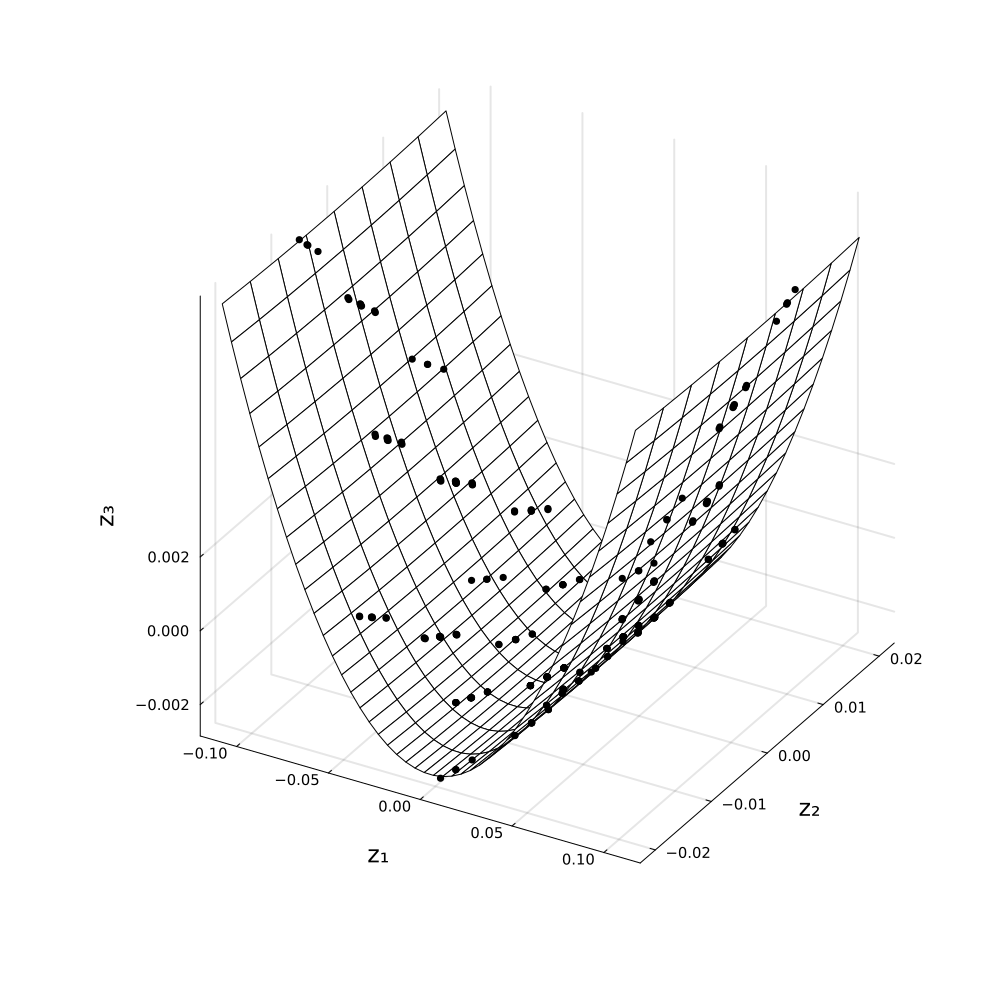

In [29]:
scatter!(eachrow(Z_)...;xlabel="z₁",ylabel="z₂",zlabel="z₃", 
    # hover= [i for i in 1:lastindex(eachcol(Z_))],
    markercolor = [:black for _ in 1:256], #[c[4] for c in conf],
    size=(1000,1000),
    label = false,
    grid = true, gridlinewidth = 2,
    tickfontsize = 10,
    guidefontsize=16,
    zticks=[-0.004:0.002:0.002...],
    markersize = 4
    )

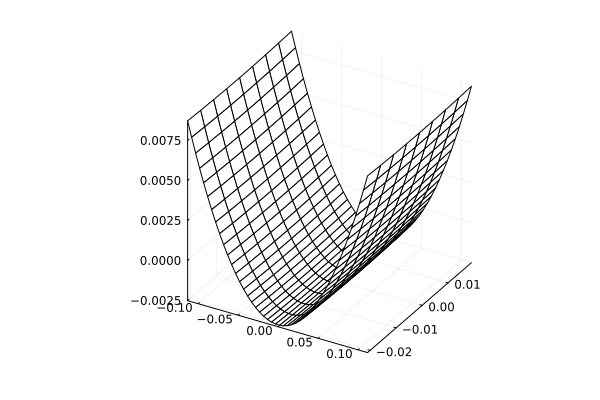

In [28]:
wireframe(
    round(minimum(Z_[1,:]),digits=3):0.005:round(maximum(Z_[1,:]),digits=3),
    round(minimum(Z_[2,:]),digits=3):0.005:round(maximum(Z_[2,:]),digits = 3),
    z3)

In [43]:
Plots.savefig("G:/My Drive/Temp/Comunication/Presentation Potential Oct/kPCA_PB4S_Manifold.svg")

"G:\\My Drive\\Temp\\Comunication\\Presentation Potential Oct\\kPCA_PB4S_Manifold.svg"

In [ ]:
# Scatter plot of the TS in RS
scatter(eachrow(Z_)...,xlabel="z1",ylabel="z2",zlabel="z3", 
hover= [i for i in 1:lastindex(eachcol(Z_))])


## Isomap

In [33]:
neighbors = 100
Y_, D_G_sym = isomap1(neighbors,Z_)


([8.621269529983221e-10 -0.0026646878528735936 … 0.002690481335871592 8.617271479217512e-10; -3.1350261424781275e-9 -0.0023628618118591974 … 0.0023724709849256387 -3.134645012514099e-9], [0.0 0.00339323778167023 … 0.003425815031638033 4.557302393400292e-13; 0.00339323778167023 0.0 … 0.006819028691780456 0.003393237781300467; … ; 0.003425815031638033 0.006819028691780456 … 0.0 0.0034258150320081895; 4.557302393400292e-13 0.003393237781300467 … 0.0034258150320081895 0.0])

In [87]:
plotlyjs()

Plots.PlotlyJSBackend()

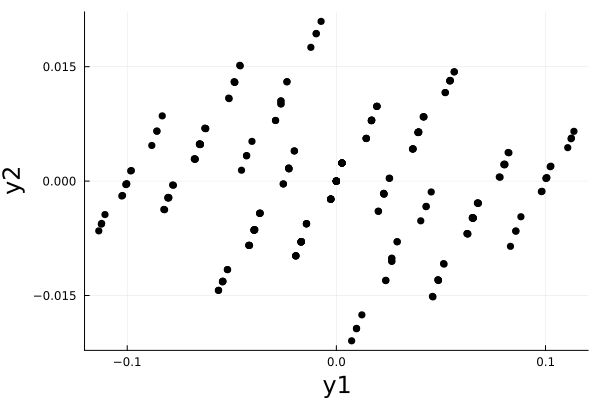

In [34]:
s = scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
label=false,
markercolor = [:black for _ in 1:256],
hover= [i for i in 1:lastindex(eachcol(Z_))],
    xticks=[-0.1,0.0,0.1],
    yticks=[-0.015,0.0,0.015],
    gridlines=false,
    guidefontsize=16,
)

In [53]:
Plots.savefig("G:/My Drive/Temp/Comunication/Presentation Potential Oct/kPCA_isomap_PB4S_Manifold.svg")

"G:\\My Drive\\Temp\\Comunication\\Presentation Potential Oct\\kPCA_isomap_PB4S_Manifold.svg"

In [ ]:
VectorSearch(Y_,[1,1,0,0],VS_Conf_list)

In [ ]:
Y_gen = []
for conf in conf
    y_gen = VectorSearch(Y_,conf,VS_Conf_list)
    push!(Y_gen,y_gen)
end
Y_gen = reduce(hcat,Y_gen)

In [ ]:
Err = norm(Y_gen-Y_)/norm(Y_)

In [ ]:
s = scatter!(eachrow(Y_gen)...,xlabel="y1",ylabel="y2",
label="Y* (ERR_TS = $(round(Err*100,digits=2))%)",legend=:outerbottom,legend_columns=2,
# markercolor = [c[1] for c in conf],
hover= [i for i in 1:lastindex(eachcol(Z_))]
)

## Optimization of the $\beta$ parameter

In [ ]:
function Objective(β)
    println("β = $β")
    # Number of principal directions to be considered
    k = 3
    #Gaussian Kernel
    Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    # Polynomial Kernel
    # Κ(X1,X2) = (X1'*X2 + 10)^2
    Λ, U, U_, Ḡ = kPOD(Κ, X, k)
    # Training Set in the reduced space
    Z_ = real.(U_'*Ḡ)
    neighbors = 25
    Y_, D_G_sym = isomap1(neighbors,Z_)
    #Generation of full set of parameters in order
    conf = []
    for i in 0:2, j in 0:2, k in 0:2, l in 0:2
    push!(conf,[i,j,k,l])
    end
    VS_Conf = [
        [2,2,2,2],
        [0,2,2,2],
        [2,0,2,2],
        [2,2,0,2],
        [2,2,2,0],
        [1,2,2,2],
        [2,1,2,2],
        [2,2,1,2],
        [2,2,2,1],
    ]

    VS_Conf_list = []
    for i in 1:9
        j = 0
        for c in conf
            j+=1
            if VS_Conf[i]==c
                push!(VS_Conf_list,j)
            end
        end
    end

    Y_gen = []
    for conf in conf
        y_gen = VectorSearch(Y_,conf,VS_Conf_list)
        push!(Y_gen,y_gen)
    end
    Y_gen = reduce(hcat,Y_gen)
    Err = norm(Y_gen-Y_)/norm(Y_)
    println("Error = $Err")
    return Err
end

In [ ]:
β_min = optimize(Objective, 0.0, 10.0, GoldenSection(),f_tol=1.0e-6,iterations=50)

In [ ]:
β_min.minimizer

## Plots

In [ ]:
s = scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
label="TS PB4S",legend=:outerbottom,
# legend_columns=2,
markercolor = [c[1] for c in conf],
hover= [i for i in 1:lastindex(eachcol(Z_))]
)

In [ ]:
gr()

In [ ]:
plotlyjs()

In [ ]:

function plot_vector1(i)
    plot!(eachrow(Y_[:,VS_Conf_list[[1,i]]])...,arrow=true,label=false,color=:black,
    )
    s = annotate!(eachrow(1.2*Y_[:,VS_Conf_list[[1,i]]])...,["", ("$(-(conf[VS_Conf_list[i]].-2))",8)]
    )
    return s
end
function plot_vector2(i)
    plot!(eachrow(Y_[:,[81,i]])...,arrow=true,label=false,color=:black,
    )
    s = annotate!(eachrow([1.15 0;0 1]*Y_[:,i])...,["", ("$(-(conf[i].-2))", 8)]
    )
    return s
end

In [ ]:
plot!(eachrow(Y_[:,VS_Conf_list[[1,3]]])...,arrow=true,label=false
)
plot!(eachrow(Y_[:,[81,21]])...,arrow=true,label=false
)
plot!(eachrow(Y_[:,[81,21]])...,arrow=true,label=false
)
plot!(eachrow(Y_[:,[27,21]])...,arrow=true,label=false
)

In [ ]:
scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
label=false
)
plot_vector1(6)
plot_vector1(7)
s = plot_vector2(45)
plot!(eachrow(Y_[:,[VS_Conf_list[6],45]])...,arrow=false,label=false,color=:black,
line = :dash
)
plot!(eachrow(Y_[:,[VS_Conf_list[7],45]])...,arrow=false,label=false,color=:black,
line = :dash
)
xlims!(1.1*minimum(Y_[1,:]),1.1*maximum(Y_[1,:]))
ylims!(1.1*minimum(Y_[2,:]),1.1*maximum(Y_[2,:]))